In [53]:
import csv
import folium
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

# sklearn: 
# Import necessary packages
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
import plotly.graph_objs as go
import plotly as plt
import seaborn as sns
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")


# folium: 
from folium import plugins
from folium.plugins import HeatMap



import colorlover as cl
from IPython.display import HTML
from IPython.display import display
import pandas as pd

# Pretty display for notebooks
%matplotlib inline


In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
accidents= pd.read_csv('gdrive/MyDrive/Road Safety Data Accident 2019.csv', low_memory=False,dtype={'Accident_index':'int','LSOA_of_Accident_Location':'str'})

In [56]:
# assesment of missing data: 
accidents.isnull().sum(axis = 0)

Accident_Index                                    0
Location_Easting_OSGR                            28
Location_Northing_OSGR                           28
Longitude                                        28
Latitude                                         28
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             63
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

In [57]:
vehicles= pd.read_csv('gdrive/MyDrive/Road Safety Data Vehicles 2019.csv', low_memory=False,dtype={'Accident_index':'int'})

In [58]:
casualties= pd.read_csv('gdrive/MyDrive/Road Safety Data Casualties 2019.csv', low_memory=False,dtype={'Accident_index':'int'})

# **DATA CLEANING/ PREPROCESSING**

In [59]:
accidents['Date']= pd.to_datetime(accidents['Date'], format="%d/%m/%Y")

In [60]:
accidents.replace(-1, 'NaN', inplace=True)
casualties.replace(-1, 'NaN', inplace=True)
vehicles.replace(-1, 'NaN', inplace=True)

In [61]:
#time series features: 
accidents['Year'] = accidents.Date.dt.year 
accidents['Month_number'] = accidents.Date.dt.month
accidents['Month'] = accidents.Date.dt.month_name()
accidents['Hour'] = accidents.apply(lambda x: str(x.Time).split(':')[0], axis=1)

In [62]:
# merge vehicle data using key (Accident_Index)
accidents = pd.merge(accidents,vehicles[['Accident_Index','Vehicle_Type','Sex_of_Driver', 'Age_of_Driver', 'Age_Band_of_Driver','Vehicle_Manoeuvre', 'Age_of_Vehicle']],on='Accident_Index', how='left')


In [63]:
accidents_cleanup = ['Longitude','Time','Number_of_Casualties','Speed_limit', 'Junction_Detail', 'Light_Conditions', 'Road_Type',
                          'Did_Police_Officer_Attend_Scene_of_Accident','Weather_Conditions', 
                          'Road_Surface_Conditions', 'Special_Conditions_at_Site','Carriageway_Hazards', 
                          'Urban_or_Rural_Area', 'Accident_Severity', '1st_Road_Class', 
                          'Pedestrian_Crossing-Human_Control', 
                          'Pedestrian_Crossing-Physical_Facilities', 
                          'Police_Force','Vehicle_Type','Sex_of_Driver', 'Police_Force','Did_Police_Officer_Attend_Scene_of_Accident', 'Age_of_Driver', 
                          'Vehicle_Manoeuvre','LSOA_of_Accident_Location']

accidents_cleanup_outliers = ['Sex_of_Driver', 'Age_Band_of_Driver']
outliers_list = ['6 - 10', '0 - 5', 'Not known']

In [64]:
# method to clean spesific features, and remove linked data points in other datasets: 
def clean_data (cleanup_features, df, df2, df3): 
    for feature in cleanup_features: 
        accidents_data_list = df[(df[feature].isnull()) | (df[feature] == 'NaN')].Accident_Index.tolist()
        df = df[~df.Accident_Index.isin(accidents_data_list)]
        df2 = df2[~df2.Accident_Index.isin(accidents_data_list)]
        df3 = df3[~df3.Accident_Index.isin(accidents_data_list)]
    return df, df2, df3

In [65]:
# method to remove outliers from spesific features, and remove linked data points in other datasets: 
def clean_outliers (cleanup_outliers, outliers_list, df, df2, df3): 
    for feature in cleanup_outliers: 
        accidents_data_list = df[(df[feature].isin (outliers_list))].Accident_Index.tolist()
        df = df[~df.Accident_Index.isin(accidents_data_list)]
        df2 = df2[~df2.Accident_Index.isin(accidents_data_list)]
        df3 = df3[~df3.Accident_Index.isin(accidents_data_list)]
    return df, df2, df3

In [66]:
# remove dublicate 
accidents.drop_duplicates(subset='Accident_Index', keep='first', inplace=True)

In [67]:
print ('accidents_data drop duplicates:', accidents.shape[0])
print ('casualties_data drop duplicates:', casualties.shape[0])
print ('vehicles_data drop duplicates:', vehicles.shape[0])

accidents_data drop duplicates: 117536
casualties_data drop duplicates: 153158
vehicles_data drop duplicates: 216381


In [68]:
# removing rows with missing values/outliers and their linked vehicles/casualties data
accidents, casualties, vehicles = clean_data(accidents_cleanup, accidents, casualties, vehicles)
accidents, casualties, vehicles = clean_outliers(accidents_cleanup_outliers, outliers_list, accidents, casualties, vehicles)

In [69]:
# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

In [70]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 15:
        return "2"
    elif hour >= 15 and hour < 19:
        return "3"
    elif hour >= 19 and hour < 23:
        return "4"
    else:
        return "5"

In [71]:
# create a little dictionary to later look up the groups 
daytime_groups = {1: 'Morning: Between 5 & 10', 
                  2: 'Office Hours: Between 10 & 15', 
                  3: 'Afternoon: Between 15 & 19', 
                  4: 'Evening: Between 19 & 23', 
                  5: 'Night: Between 23 & 5'}

In [72]:
#created a temporary column
accidents['Day_time'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Day_time']].head()

,Time,Hour,Day_time
4,01:50,1,5
6,01:20,1,5
7,00:40,0,5
9,02:45,2,5
11,01:35,1,5


In [73]:
accidents['Day_time'].head(20)

4     5
6     5
7     5
9     5
11    5
12    5
15    5
17    5
20    5
21    5
22    5
25    5
29    5
35    1
37    1
39    2
41    3
42    1
44    2
46    2
Name: Day_time, dtype: object

In [74]:
# drop old time column and temporary hour column
accidents = accidents.drop(columns=['Time', 'Hour'])

In [75]:
print('Proportion of Missing Values in Accidents Table:', 
      round(accidents.isna().sum().sum()/len(accidents), 3), '%')

Proportion of Missing Values in Accidents Table: 0.0 %


In [76]:
accidents = accidents.dropna()


In [77]:
for col in set(accidents.columns) - set(accidents.describe().columns):
    accidents[col] = accidents[col].astype('category')

In [78]:
# combine the accidents with the vehicles table
df = pd.merge(accidents[['Accident_Index','Day_time','Speed_limit', 'Did_Police_Officer_Attend_Scene_of_Accident','Urban_or_Rural_Area', 'Location_Easting_OSGR', 'Weather_Conditions', 'Number_of_Casualties','Road_Surface_Conditions', 'Road_Type', 'Light_Conditions']], 
              vehicles[['Accident_Index', 'Vehicle_Type','Vehicle_Manoeuvre','Sex_of_Driver', 'Age_Band_of_Driver']],
              
              on='Accident_Index')


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169608 entries, 0 to 169607
Data columns (total 15 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   Accident_Index                               169608 non-null  object  
 1   Day_time                                     169608 non-null  category
 2   Speed_limit                                  169608 non-null  category
 3   Did_Police_Officer_Attend_Scene_of_Accident  169608 non-null  int64   
 4   Urban_or_Rural_Area                          169608 non-null  int64   
 5   Location_Easting_OSGR                        169608 non-null  float64 
 6   Weather_Conditions                           169608 non-null  int64   
 7   Number_of_Casualties                         169608 non-null  int64   
 8   Road_Surface_Conditions                      169608 non-null  category
 9   Road_Type                                    169

In [80]:
Merged = pd.merge(df, casualties, on='Accident_Index')

In [81]:
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237962 entries, 0 to 237961
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   Accident_Index                               237962 non-null  object  
 1   Day_time                                     237962 non-null  category
 2   Speed_limit                                  237962 non-null  category
 3   Did_Police_Officer_Attend_Scene_of_Accident  237962 non-null  int64   
 4   Urban_or_Rural_Area                          237962 non-null  int64   
 5   Location_Easting_OSGR                        237962 non-null  float64 
 6   Weather_Conditions                           237962 non-null  int64   
 7   Number_of_Casualties                         237962 non-null  int64   
 8   Road_Surface_Conditions                      237962 non-null  category
 9   Road_Type                                    237

In [82]:
# combine the accidents with the vehicles table
df = pd.merge(Merged[['Accident_Index','Day_time', 'Pedestrian_Location', 'Pedestrian_Movement', 'Speed_limit', 'Urban_or_Rural_Area','Did_Police_Officer_Attend_Scene_of_Accident', 'Weather_Conditions', 'Number_of_Casualties','Road_Surface_Conditions', 'Road_Type', 'Light_Conditions']], 
              casualties[['Accident_Index', 'Casualty_Type','Casualty_Severity','Sex_of_Casualty', 'Age_of_Casualty']],
              
              on='Accident_Index')

df.isna().sum()

Accident_Index                                 0
Day_time                                       0
Pedestrian_Location                            0
Pedestrian_Movement                            0
Speed_limit                                    0
Urban_or_Rural_Area                            0
Did_Police_Officer_Attend_Scene_of_Accident    0
Weather_Conditions                             0
Number_of_Casualties                           0
Road_Surface_Conditions                        0
Road_Type                                      0
Light_Conditions                               0
Casualty_Type                                  0
Casualty_Severity                              0
Sex_of_Casualty                                0
Age_of_Casualty                                0
dtype: int64

In [83]:
# define categorical feature columns
category_cols = ['Day_time', 'Pedestrian_Location', 'Pedestrian_Movement','Speed_limit', 'Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Number_of_Casualties','Weather_Conditions', 
                 'Road_Surface_Conditions', 'Road_Type']

# define target col
target_col = ['Urban_or_Rural_Area']

cols = category_cols  + target_col

# copy dataframe - just to be safe
df = df[cols].copy()
df.shape

(463192, 11)

In [84]:
#create dummy variables from the categorical features
dummies = pd.get_dummies(df[category_cols], drop_first=True)
df = pd.concat([ df[target_col], dummies], axis=1)
df.shape

(463192, 33)

In [85]:
# Train Test Split
y = df['Urban_or_Rural_Area']
X = df.drop('Urban_or_Rural_Area', axis=1)

In [86]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## **MODELLING**

In [87]:
def get_dataset():
    X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size=.25,random_state=1)
    return X_train, y_train

In [88]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, 
error_score='raise')
    return scores

In [89]:
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['lr'] = LogisticRegression()
    models['rcf'] = RandomForestClassifier()
    models['nb'] = MultinomialNB()
    
    
    return models

In [ ]:
X, y = get_dataset()
#Grab the models to use.
models = get_models()
#Run and Evaluate the models.
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>dtree 0.886 (0.002)
>knn 0.869 (0.006)
>lr 0.858 (0.002)
>rcf 0.887 (0.002)
>nb 0.818 (0.002)


In [ ]:
from matplotlib import pyplot

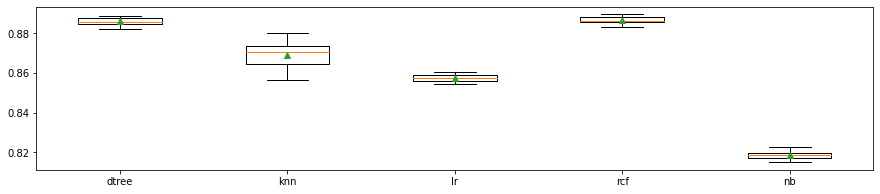

In [ ]:
plt.figure(figsize=(15,3))


pyplot.boxplot(results, labels=names,  showmeans=True)


pyplot.show()

*SINCE RANDOM FOREST WORKS WELL WITH IMBALNCED DATASET AND ALSO PRODUCED A GOOD RESULT UPON STACKING WITH OTHER MODELS, I WILL PROCEED WITH THE MODELLING WITH RANDOM FOREST*

# **CLASSIFICATION WITH RANDOM FOREST**

In [ ]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
# import classifier
from sklearn.ensemble import RandomForestClassifier

# import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import evaluation tools
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# instantiate RandomForestClassifier with entropy and class_weight
forest_1 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1)

# train
forest_1.fit(X_train, y_train)

# predict
y_test_preds  = forest_1.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy: \n', report)

Classification Report Random Forest - with Entropy: 
               precision    recall  f1-score   support

           1       0.87      0.92      0.89     45487
           2       0.91      0.84      0.88     41362

    accuracy                           0.89     86849
   macro avg       0.89      0.88      0.89     86849
weighted avg       0.89      0.89      0.89     86849



In [ ]:
# cross-validation with F1 score (more appropriate to imbalanced classes)
cross_val_score(forest_1, X_train, y_train, scoring='f1_macro', n_jobs=-1)

array([0.88567759, 0.88643951, 0.88225659, 0.88561231, 0.88553646])

In [ ]:
forest_1.predict_proba(X_test)[:,1]

array([0.15132616, 0.17125227, 0.16339618, ..., 0.1881943 , 1.        ,
       0.25034321])

In [ ]:
import sklearn.metrics as metrics


In [ ]:
cf_matrix = metrics.confusion_matrix(y_test, y_test_preds)
print(cf_matrix)

[[42068  3419]
 [ 6485 34877]]


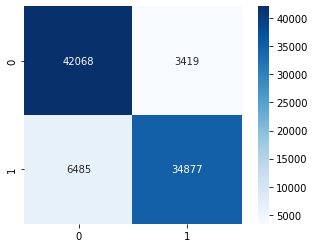

In [ ]:
sns.heatmap(cf_matrix, square=True, annot=True, cmap='Blues',fmt='d',cbar=True);

# **Training Random Forest Classifier with SMOTE**










Let's try one of the resampling strategies to deal properly with our imbalances target classes: Synthetic Minority Over-sampling Technique (SMOTE). Here we're repeatedly sample with replacement from the minority class to make it of equal size as the majority class. To be more specific: We're creating new synthetic data for the minority class - that is representative but not exact duplicate - using K-Nearest Neighbors.

In [ ]:
from imblearn.over_sampling import SMOTE


In [ ]:
# view previous class distribution
print('Before Upsampling with SMOTE:'), print(df['Urban_or_Rural_Area'].value_counts())

oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X, y)

# view synthetic sample class distribution
print('\nAfter Upsampling with SMOTE:'), print(pd.Series(y_resample).value_counts())

In [ ]:
# then perform ususal train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, random_state=0)

In [ ]:
# instantiate second RandomForestClassifier with entropy and SMOTE
forest_2 = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1)

# train
forest_2.fit(X_train, y_train)

# predict
y_test_preds = forest_2.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - with Entropy and SMOTE Upsampling: \n', report)

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test, y_test_preds)
print(cf_matrix)

In [ ]:
sns.heatmap(cf_matrix, square=True, annot=True, cmap='Blues',fmt='d',cbar=True);

In [ ]:
# plot the important features
feat_importances = pd.Series(forest_2.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest');

# **MODELLING WITH ANN**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense



In [ ]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:

 
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
#Initialising ANN
import tensorflow as tf

ann = tf.keras.models.Sequential()


In [ ]:
 #Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
 #Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
 #Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [ ]:
#Compiling ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
#Fitting ANN
ann.fit(X_train,y_train,batch_size=20,epochs = 10)